In [ ]:
!nvidia-smi

Mon Nov  6 11:11:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install patchify

In [ ]:
!pip install tensorflow

In [ ]:
import keras
import random
%matplotlib_inline
import numpy as np
from skimage import io
import tensorflow as tf
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import load_model
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.src.utils.layer_utils import print_summary
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda

# 3D Convolutional Block Definition
In this code cell, a 3D convolutional block is defined for use in a neural network model. This block consists of two 3D convolutional layers with batch normalization and ReLU activation functions, and it is applied to a given input layer.

In [ ]:
def conv_block(input_layer, num_filters):
    x = Conv3D(num_filters, (3, 3, 3), padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv3D(num_filters, (3, 3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


input_layer = Input(shape=(64, 64, 64, 3))
output = conv_block(input_layer, num_filters=64)
model = Model(inputs=input_layer, outputs=output)

# Encoder Block Definition
This code cell defines an encoder block for a 3D convolutional neural network.The encoder block is applied to a given input layer, and it produces two outputs: encoder_output_x from the convolutional block and encoder_output_p from the max-pooling operation.

In [ ]:
def encoder_block(input_layer, num_filters):
    x = conv_block(input_layer, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p


input_layer = Input(shape=(64, 64, 64, 3))
encoder_output_x, encoder_output_p = encoder_block(input_layer, num_filters=64)

# Decoder Block Definition
Code defines a decoder block for a 3D convolutional neural network.In this the decoder block is applied to a given input layer and skip features. This operation plays a critical role in the reverse process of upsampling and reconstructing data to its original dimension after encoding and downsampling in the encoder blocks.

In [ ]:
def decoder_block(input_layer, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=(2, 2, 2), padding="same")(input_layer)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


input_layer = Input(shape=(32, 32, 32, 64))
skip_features = Input(shape=(64, 64, 64, 32))
decoder_output = decoder_block(input_layer, skip_features, num_filters=32)


# U-Net Architecture Definition
In this, the U-Net architecture is defined as a function, 'build_unet'. The network comprises encoder and decoder blocks, which progressively downsample and then upsample the input data, and a bridge connecting them. The number of classes in the output determines the final layer's activation function, either 'sigmoid' for binary or 'softmax' for multiclass classification.

In [ ]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv3D(n_classes, (1, 1, 1), padding="same", activation=activation)(d4)  # Change the activation based on n_classes

    model = Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model


input_shape = (128, 128, 128, 3)
n_classes = 1  # Number of output classes
unet_model = build_unet(input_shape, n_classes)

# U-Net Model Initialization
In this code, a U-Net model is initialized using the build_unet function. The U-Net architecture is constructed with specific input shape and the desired number of output classes.


In [ ]:
input_shape = (64, 64, 64, 3)
n_classes = 4  # Number of output classes
my_model = build_unet(input_shape, n_classes)

# Model Summary

In [ ]:
my_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 conv3d_25 (Conv3D)          (None, 64, 64, 64, 64)       5248      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_24 (Ba  (None, 64, 64, 64, 64)       256       ['conv3d_25[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 64, 64, 64, 64)       0         ['batch_normalization_24[0

# Input Shape Inquiry

In [ ]:
my_model.input_shape

(None, 64, 64, 64, 3)

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.14.0
2.14.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Input Images and Masks

In [ ]:
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training.
image = io.imread('/content/drive/MyDrive/3D_image_segmentation/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)

mask = io.imread('/content/drive/MyDrive/3D_image_segmentation/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)

# Image Visualization

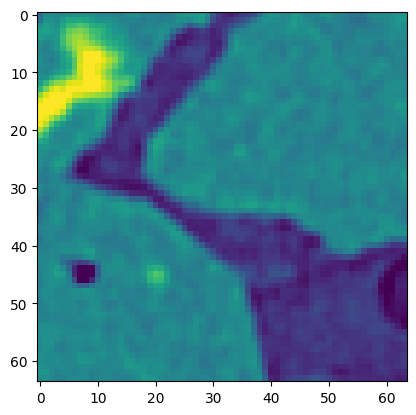

In [ ]:
plt.imshow(img_patches[1,2,3,:,:,32])

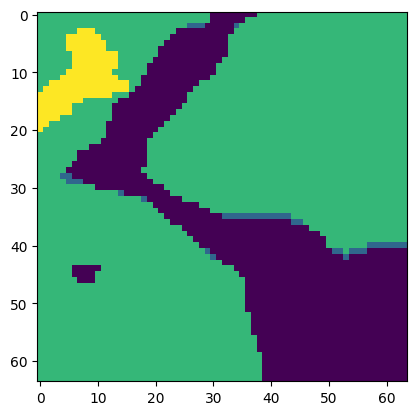

In [ ]:
plt.imshow(mask_patches[1,2,3,:,:,32])

# Reshaping Image and Mask Patches
 The code reshapes 5D NumPy arrays, img_patches and mask_patches, into 4D arrays to prepare them for further processing. The resulting shapes of input_img and input_mask are printed for reference.

In [ ]:
# Assuming img_patches and mask_patches are 5D NumPy arrays
input_img = img_patches.reshape(-1, img_patches.shape[-3], img_patches.shape[-2], img_patches.shape[-1])
input_mask = mask_patches.reshape(-1, mask_patches.shape[-3], mask_patches.shape[-2], mask_patches.shape[-1])

print(input_img.shape)

(64, 64, 64, 64)


In [ ]:
n_classes=4

# Data Preprocessing and Splitting
It converts a grayscale image into a 3-channel image, normalizes the image data, expands the dimensions of the mask, and converts the mask into one-hot encoding. Finally, it splits the data into training and testing sets using a 90-10 ratio.

In [ ]:
# Assuming input_img and input_mask are available
n_classes = 4

# Convert grayscale image to 3 channels by copying the channel 3 times
train_img = np.repeat(input_img, 3, axis=-1)

# Normalize the image data
train_img = train_img / 255.0

# Expand dimensions for the mask
train_mask = np.expand_dims(input_mask, axis=-1)

# Convert the mask to one-hot encoding
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size=0.2, random_state=0)

# Custom Dice Coefficient and Dice Coefficient Loss Functions
This cell defines two custom functions for calculating the Dice coefficient and the Dice coefficient loss.The dice_coefficient function calculates the Dice coefficient between two input tensors, while the dice_coefficient_loss function computes the loss based on the Dice coefficient.

In [ ]:
def dice_coefficient(y_true, y_pred, smoothing_factor=1):
    flat_y_true = tf.reshape(y_true, [-1])
    flat_y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(flat_y_true * flat_y_pred)
    return (2.0 * intersection + smoothing_factor) / (tf.reduce_sum(flat_y_true) + tf.reduce_sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# Model Configuration and Hyperparameters
In this cell, the patch size for input data is set to 64, and the number of channels in the input data is defined as 3, indicating a 3-channel image. Additionally, a learning rate of 0.0001 is chosen for the Adam optimizer

In [ ]:
patch_size = 64
channels = 3

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

#  Model Definition and Initialization
 In this cell, a neural network model is defined.The model is built using the build_unet function, which takes the specified input shape and the number of classes as parameters. This step is essential for creating the architecture of the model that will be used for tasks where the model learns to classify pixels into one of the specified classes.

In [ ]:
input_shape = (patch_size, patch_size, patch_size, channels)
n_classes = 4

model = build_unet(input_shape, n_classes)

# Model Compilation and Summary
It specifies the optimizer (in this case, the Adam optimizer with the defined learning rate), the loss function (Dice coefficient loss), and the evaluation metric (Dice coefficient). After compilation, it prints a summary of the model's architecture, providing details about the layers, parameters, and output shapes.

In [ ]:
model.compile(optimizer=optimizer, loss=dice_coefficient_loss, metrics=[dice_coefficient])
print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 conv3d_44 (Conv3D)          (None, 64, 64, 64, 64)       5248      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_42 (Ba  (None, 64, 64, 64, 64)       256       ['conv3d_44[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_42 (Activation)  (None, 64, 64, 64, 64)       0         ['batch_normalization_42[0

#  Data Reshaping for Model Compatibility
In this cell, the training and testing data, represented by X_train and X_test, are reshaped to match the expected input shape of the neural network model.

In [ ]:
# Reshape input data to match the expected shape of the model
X_train = X_train.reshape(-1, 64, 64, 64, 3)

# Also reshape X_test to match the model's input shape
X_test = X_test.reshape(-1, 64, 64, 64, 3)

# Model and Data Information
various aspects related to the model and input data are displayed for reference. The model.input_shape and model.output_shape provide information about the expected shape of the model's input and output, respectively. Additionally, the shapes of the training data (X_train and y_train) are printed to check their compatibility with the model. Finally, the maximum value in the training data is displayed for insight into the data range.

In [ ]:
print(model.input_shape)
print(X_train.shape)
print(model.output_shape)
print(y_train.shape)
print("-------------------")
print(X_train.max())

(None, 64, 64, 64, 3)
(51, 64, 64, 64, 3)
(None, 64, 64, 64, 4)
(51, 64, 64, 64, 4)
-------------------
1.0


# Model Training
 In this cell, the neural network model is trained using the training data (X_train and y_train) for 20 epochs with a batch size of 8. The training progress and metrics are displayed (verbose=1), and validation data is used to evaluate the model's performance during training.

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=8,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/20
7/7 [==============================] - 121s 8s/step - loss: 0.5689 - dice_coefficient: 0.4400 - val_loss: 0.7662 - val_dice_coefficient: 0.2337
Epoch 2/20
7/7 [==============================] - 25s 4s/step - loss: 0.3741 - dice_coefficient: 0.6255 - val_loss: 0.7563 - val_dice_coefficient: 0.2437
Epoch 3/20
7/7 [==============================] - 25s 4s/step - loss: 0.3126 - dice_coefficient: 0.6901 - val_loss: 0.7189 - val_dice_coefficient: 0.2814
Epoch 4/20
7/7 [==============================] - 25s 4s/step - loss: 0.2716 - dice_coefficient: 0.7268 - val_loss: 0.6864 - val_dice_coefficient: 0.3143
Epoch 5/20
7/7 [==============================] - 25s 4s/step - loss: 0.2427 - dice_coefficient: 0.7549 - val_loss: 0.6606 - val_dice_coefficient: 0.3402
Epoch 6/20
7/7 [==============================] - 26s 4s/step - loss: 0.2226 - dice_coefficient: 0.7780 - val_loss: 0.6392 - val_dice_coefficient: 0.3618
Epoch 7/20
7/7 [==============================] - 25s 4s/step - loss: 0.209

# Save the Model

In [ ]:
model.save('/content/drive/MyDrive/3D_image_segmentation/Copy of Image_segmentation.ipynb/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training Progress Visualization
This extracts and plots the training and validation loss, as well as the Dice coefficient values, from the history object. The left subplot displays the training and validation loss over the training epochs, providing insights into the model's convergence and generalization. The right subplot shows the training and validation Dice coefficients.These visualizations help assess the model's performance and its ability to generalize to unseen data.

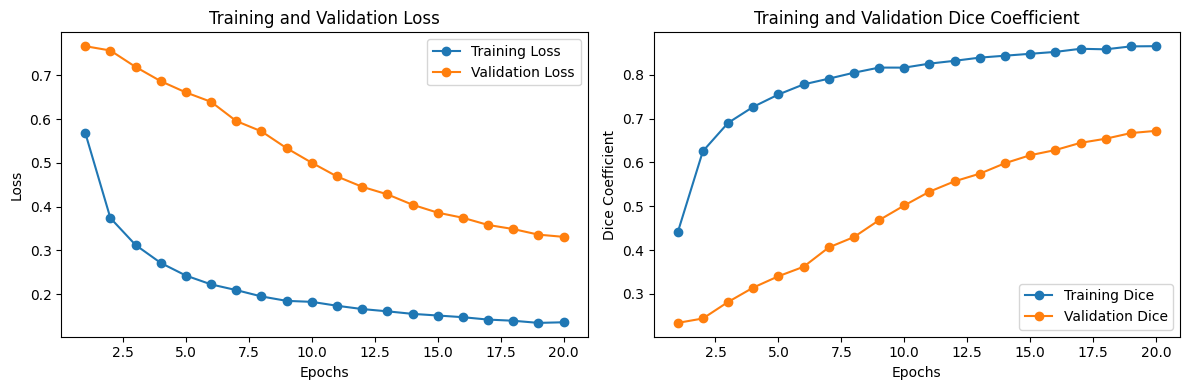

In [ ]:
# Extract training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation Dice coefficient from the history object
dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation Dice coefficient
plt.subplot(1, 2, 2)
plt.plot(range(1, len(dice_coefficient) + 1), dice_coefficient, label='Training Dice', marker='o')
plt.plot(range(1, len(val_dice_coefficient) + 1), val_dice_coefficient, label='Validation Dice', marker='o')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

# Load the Model

In [ ]:
my_model = load_model('/content/drive/MyDrive/3D_image_segmentation/my_model.h5', compile=False)

In [ ]:
my_model.compile(optimizer=optimizer, loss=dice_coefficient_loss, metrics=[dice_coefficient])

# Test Data Prediction and Post-processing
The trained model is used to make predictions on the test data (X_test). The resulting predictions are stored in y_pred. To facilitate further analysis and evaluation, the predictions are processed using np.argmax to obtain the class index with the highest probability along the last axis (axis=4). Similarly, np.argmax is applied to y_test to obtain the corresponding ground truth class indices.

In [ ]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

1/1 [==============================] - 0s 473ms/step


# Prediction and Ground Truth Shape and Class Labels
The y_pred_argmax and y_test_argmax shapes indicate the dimensions of the processed predictions and ground truth data.The np.unique function is used to find the unique class labels present in the predicted data.

In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(13, 64, 64, 64)
(13, 64, 64, 64)
[1 2]


# Calculate Mean IOU

In [ ]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)

mean_iou = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou)

Mean IoU = 0.20621452


 # Single Test Image Prediction and Ground Truth Comparison
 In this a random index is generated to select a single test image from the test dataset. The selected test image and its corresponding ground truth are extracted. The input image is expanded to match the model's expected input shape, and predictions are generated using the model.The ground_truth_argmax variable is also calculated to find the class indices for the ground truth. This allows for a comparison between the model's prediction and the actual ground truth for the selected test image.

In [ ]:
# Generate a random index for testing
test_img_index = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_index]
ground_truth = y_test[test_img_index]

# Expand dimensions for the input image
test_img_input = np.expand_dims(test_img, axis=0)

# Predict using the model
test_pred = model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=-1)[0]

# Calculate the argmax for the ground truth
ground_truth_argmax = np.argmax(ground_truth, axis=-1)

print(ground_truth_argmax.shape)

1/1 [==============================] - 0s 34ms/step
(64, 64, 64)


# Visualization of Random Slice Comparison
In this cell, a random slice index is generated, and a figure is created to display the slices of the testing image, testing label (ground truth), and the model's prediction on a specific slice. The selected slice allows for a focused comparison between the image, ground truth, and model prediction.

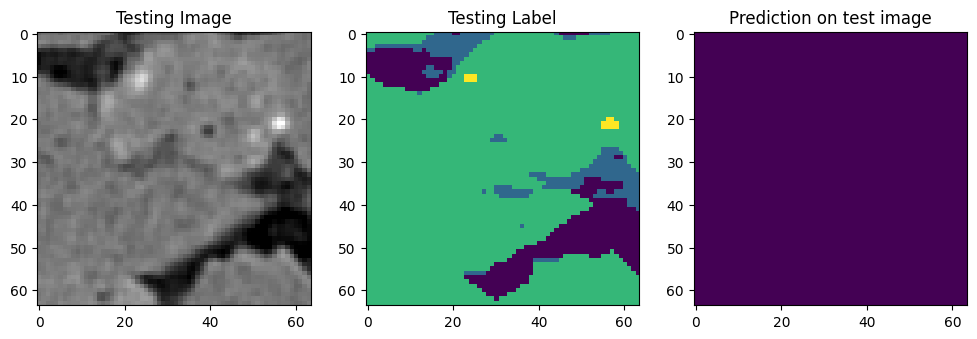

In [ ]:
# Generate a random slice index
slice = random.randint(0, test_prediction.shape[2] - 1)

# Create a figure and display the slices
plt.figure(figsize=(12, 8))

# Plot the testing image slice
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_input[0, :, :, slice, 0], cmap='gray')

# Plot the testing label slice
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[:, :, slice])

# Plot the prediction on the test image slice
plt.subplot(233)
plt.title('Prediction on the test image')
plt.imshow(test_prediction[:, :, slice])

plt.show()

1/1 [==============================] - 0s 437ms/step
Test Prediction Shape: (64, 64, 64)
Ground Truth Shape: (64, 64, 64)


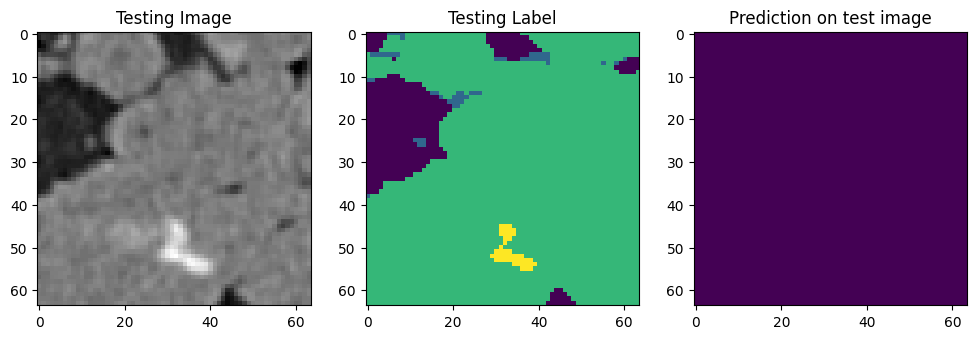

In [ ]:
# Load the trained model
loaded_model = load_model('/content/drive/MyDrive/3D_image_segmentation/my_model.h5', compile=False)

# Compile the loaded model with the appropriate settings
loaded_model.compile(optimizer=optimizer, loss=dice_coefficient_loss, metrics=[dice_coefficient])

# Choose a random index for testing
test_img_index = random.randint(0, len(X_test) - 1)

# Select the test image and its corresponding ground truth
test_img = X_test[test_img_index]
ground_truth = y_test[test_img_index]

# Expand dimensions for the input image
test_img_input = np.expand_dims(test_img, axis=0)

# Make predictions using the loaded and compiled model
test_pred = loaded_model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=-1)[0]

# Calculate the argmax for the ground truth
ground_truth_argmax = np.argmax(ground_truth, axis=-1)

# Print the shapes of the arrays for verification
print("Test Prediction Shape:", test_prediction.shape)
print("Ground Truth Shape:", ground_truth_argmax.shape)

# Visualize the slices
slice = random.randint(0, test_prediction.shape[2] - 1)

# Create a figure and display the slices
plt.figure(figsize=(12, 8))

# Plot the testing image slice
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_input[0, :, :, slice, 0], cmap='gray')

# Plot the testing label slice
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[:, :, slice])

# Plot the prediction on the test image slice
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[:, :, slice])

plt.show()


# Image Patch Extraction for 3D Image Segmentation
Break down the large 3D image volume into smaller patches, each with the same size as the training images (64x64x64). These patches are generated using a step size of 64, ensuring minimal overlap between adjacent patches.

In [ ]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/content/drive/MyDrive/3D_image_segmentation/data_for_3D_Unet/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


# Prediction of 3D Patches Using Trained Model
 In this we predict the segmentation masks for each 3D patch extracted from the large image using a trained model. The loop iterates through all patches, preprocesses each patch, feeds it to the model, and collects the predicted segmentation masks. These individual predictions will be combined to reconstruct the final segmented 3D image.

In [ ]:
# Predict each 3D patch
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch = single_patch_3ch/255.
      single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

1/1 [==============================] - 0s 24ms/step


# stacking Predicted Packages for Reconstructed 3D Segmentation
The predicted segmentation masks for individual 3D patches are stacked together to create a single 3D volume of predictions. The resulting 'predicted_patches' now represents the reconstructed segmentation mask for the entire large 3D image, enabling further analysis and visualization

In [ ]:
# Assuming you have a list of patches named `predicted_patches`
predicted_patches = np.stack(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


# Reshaping the Predicted Packages for consistency
The NumPy array containing the predicted segmentation masks, 'predicted_patches,' is reshaped to ensure consistency with the original shape of the patches. The 'predicted_patches_reshaped' now matches the dimensions of the extracted patches, making it ready for further processing and visualization in alignment with the original image volume.

In [ ]:
# Assuming you have the NumPy array `predicted_patches`
new_shape = (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3], patches.shape[4], patches.shape[5])
predicted_patches_reshaped = predicted_patches.reshape(new_shape)
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


# Reconstructing Segmented Image from Patches
In this the individually predicted patches are repatched to reconstruct the segmented image in its original volume shape. The 'reconstructed_image' now represents the fully segmented 3D image volume, ready for analysis and visualization

In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [ ]:
print(reconstructed_image.dtype)

uint8


# Converting to Unit8 for Image Viewing Compatibility
This step allows for easy visualization and analysis of the segmented 3D image."

In [ ]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [ ]:
print(np.unique(reconstructed_image))

[2]
